In [1]:
from __future__ import annotations

import pickle

import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from edpyt.dmft import DMFT, Gfimp
from edpyt.nano_dmft import Gfimp as nanoGfimp
from edpyt.nano_dmft import Gfloc
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

plt.rcParams.update({
    'font.size': 14,           # Increase the font size
    'font.weight': 'bold',     # Make the font bold
    'axes.labelsize': 16,      # Axis label size
    'axes.titlesize': 18,      # Title size
    'axes.labelweight': 'bold',  # Bold axis labels
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'xtick.major.width': 1.2,  # X-axis major tick width
    'ytick.major.width': 1.2,  # Y-axis major tick width
    'axes.linewidth': 1.5,     # Axis line width
})


[anooja-ThinkPad-X1-Carbon-Gen-11:19772] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
def distance(delta):
    global delta_prev
    delta_prev[:] = delta
    return dmft.distance(delta)


def save_sigma(sigma_diag, outputfile, npsin):
    L, ne = sigma_diag.shape
    sigma = np.zeros((ne, L, L), complex)

    def save(spin):
        for diag, mat in zip(sigma_diag.T, sigma):
            mat.flat[:: (L + 1)] = diag
        np.save(outputfile, sigma)

    for spin in range(nspin):
        save(spin)

def plot_atomic_positions_with_occupancy(atoms, element_colors, occupancy,title):

    fig, ax = plt.subplots(figsize=(10, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    occupancy_index = 0
    for i, (xi, yi, atom) in enumerate(zip(x, y, atoms)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


        if atom.symbol in ['C', 'N']:
            ax.text(
                xi + 0.2, yi,
                f"{occupancy[occupancy_index]:.2f}",
                color='blue', fontsize=9, ha='left', va='center'
            )
            occupancy_index += 1

    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title(title)

    plt.show()


In [3]:
def plot(gf, sigma_func, semilogy=True, reference_gf=None, label_ref="DFT"):
    """Plot the Green's function DOS and Tr(Sigma) with an optional reference DOS."""

    fig, axes = plt.subplots(2, 1, sharex=True)
    ax1, ax2 = axes

    w = z_ret.real
    dos = -1 / np.pi * gf(z_ret).sum(0).imag
    if semilogy:
        ax1.semilogy(w, dos, label="DMFT") if dos.ndim == 1 else ax1.semilogy(
            w, dos[0], label=r"spin $\uparrow$"
        )
    else:
        ax1.plot(w, dos, label="DMFT") if dos.ndim == 1 else ax1.plot(
            w, dos[0], label=r"spin $\uparrow$"
        )

    if reference_gf is not None:
        reference_dos = -1 / np.pi * reference_gf(z_ret).sum(0).imag
        ax1.plot(
            w, reference_dos, linestyle="--", label=label_ref
        ) if reference_dos.ndim == 1 else ax1.plot(
            w,
            reference_dos[0],
            linestyle="--",
            label=label_ref,
        )

    ax1.set_ylabel("DOS [a.u.]")
    ax1.legend(loc="upper right")

    ax1.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    sigma = sigma_func(z_ret)
    trace_sigma = sigma.sum(axis=0)
    ax2.plot(w, trace_sigma.real, label="Re Tr(Sigma)", color="blue")
    ax2.plot(w, trace_sigma.imag, label="Im Tr(Sigma)", color="orange")

    ax2.set_xlabel("E-E$_F$ [eV]")
    ax2.set_ylabel("Tr(Sigma) [eV]")
    ax2.legend(loc="upper right")

    plt.subplots_adjust(hspace=0)
    return ax1


def callback(*args, **kwargs):

    def sigma_func(z):
        return (
            -double_counting.diagonal()[:, None]
            - gfloc_with_dccorrection.mu
            + gfloc_with_dccorrection.Sigma(z)
        )

    _ = plot(
        gf=gfloc_with_dccorrection,
        sigma_func=sigma_func,
        reference_gf=gfloc_no_dccorrection,
        label_ref="DFT",
        semilogy=kwargs.get("semilogy", True),
    )
    plt.xlim(-2, 2)
    plt.show()
    plt.close()

In [4]:
atoms = read('dft/device/scatt.xyz')
filtered_atoms = atoms[[atom.symbol not in ['H', 'Au'] for atom in atoms]]
element_colors = {'C': 'cyan', 'N': 'green'}

In [5]:
data_folder = "output/lowdin"
occupancy_goal = np.load(f"{data_folder}/occupancies.npy")
H_active = np.load(f"{data_folder}/bare_hamiltonian.npy").real
z_mats = np.load(f"{data_folder}/matsubara_energies.npy")
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
dft_dos = np.load(f"{data_folder}/dft_dos.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy",allow_pickle=True)

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
	hs_list_ii = pickle.load(f)

with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
	hs_list_ij = pickle.load(f)

nbaths = 4
U = 4.0
tol = 1e-4
max_iter = 1000
alpha = 0.0
nspin = 1
len_active = occupancy_goal.size
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
# eta = 5e-3
eta = 3e-2
z_ret = energies + 1.j * eta
beta = 1000
adjust_mu = True
use_double_counting = True

In [6]:
hyb_mats = np.fromfile(f"{data_folder}/matsubara_hybridization.bin", complex).reshape(
    z_mats.size,
    len_active,
    len_active,
)
_HybMats = interp1d(z_mats.imag, hyb_mats, axis=0, bounds_error=False, fill_value=0.0)
HybMats = lambda z: _HybMats(z.imag)

hyb_ret = np.fromfile(f"{data_folder}/hybridization.bin", complex).reshape(
    z_ret.size,
    len_active,
    len_active,
)
_HybRet = interp1d(z_ret.real, hyb_ret, axis=0, bounds_error=False, fill_value=0.0)
HybRet = lambda z: _HybRet(z.real)

# HybMats = lambda z: 0.0
# HybRet = lambda z: 0.0

S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

V = np.eye(len_active) * U
# V = np.loadtxt(f"{data_folder}/U_matrix.txt")

# Apply double counting correction if specified
double_counting = (
    np.diag(V.diagonal() * (occupancy_goal - 0.5))
    if use_double_counting
    else np.zeros((len_active, len_active))
)
gfloc_with_dccorrection = Gfloc(
    H_active - double_counting,
    S_active,
    HybMats,
    idx_neq,
    idx_inv,
    nmats=z_mats.size,
    beta=beta,
)

nimp = gfloc_with_dccorrection.idx_neq.size
gfimp = [Gfimp(nbaths, z_mats.size, V[i, i], beta) for i in range(nimp)]
gfimp = nanoGfimp(gfimp)

In [7]:
Sigma = lambda z: np.zeros((nimp, z.size), complex)

In [8]:
gfloc_no_dccorrection = Gfloc(H_active ,S_active, HybMats, idx_neq, idx_inv, nmats=z_mats.size, beta=beta)
gfloc_no_dccorrection.update(mu=1e-3)
gfloc_no_dccorrection.set_local(Sigma)
dos = -1 / np.pi * gfloc_no_dccorrection(z_ret).sum(0).imag
x, peaks = find_peaks(dos, height=5)
z_ret[x]

array([0.+0.03j])

In [9]:
occupancy_goal

array([1.86096433, 1.03542909, 1.00326866, 0.94769187, 0.96615353,
       1.08767573, 0.99619232, 1.03493842, 1.85498522])

In [10]:
gfloc_occ = gfloc_no_dccorrection.integrate(mu=9e-4)
gfloc_occ

array([1.8518415 , 1.02872491, 1.00556654, 0.95489273, 0.93170789,
       1.08085048, 0.99871552, 1.0288431 , 1.84704828])

In [11]:
# occupancy_goal = gfloc_occ.sum()

In [12]:
# Initialize DMFT with adjust_mu parameter
dmft = DMFT(
    gfimp,
    gfloc_with_dccorrection,
    occupancy_goal,
    max_iter=max_iter,
    tol=tol,
    adjust_mu=adjust_mu,
    alpha=alpha,
    DC=double_counting,
)

In [19]:
delta = dmft.initialize(V.diagonal().mean(), Sigma, mu=0.4)
delta_prev = delta.copy()
dmft.delta = delta

Iteration :  0
Occupation : 10.78730 Chemical potential : -0.13324 Error : 434.60986305 Relative Error : 1.08253917
Iteration :  1
Occupation : 10.78730 Chemical potential : -0.14493 Error : 261.43195620 Relative Error : 0.49246124


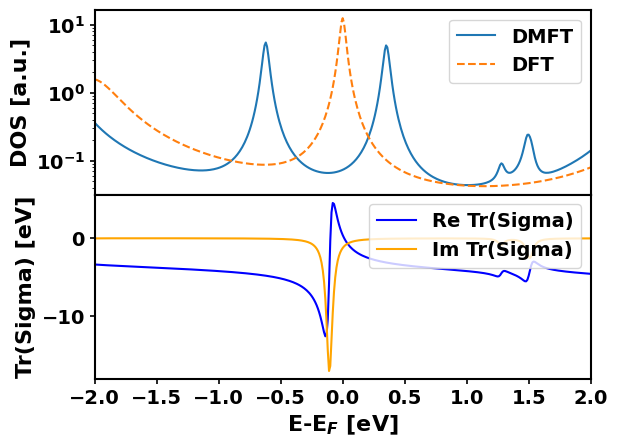

0:  |F(x)| = 39.2531; step 1
Iteration :  2
Occupation : 10.78730 Chemical potential : 0.00535 Error : 203.45243389 Relative Error : 0.38874327


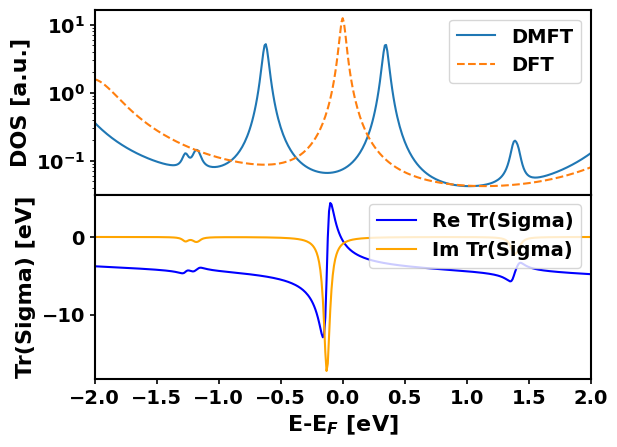

1:  |F(x)| = 27.3693; step 1
Iteration :  3
Occupation : 10.78730 Chemical potential : 0.06060 Error : 107.67661078 Relative Error : 0.16984577


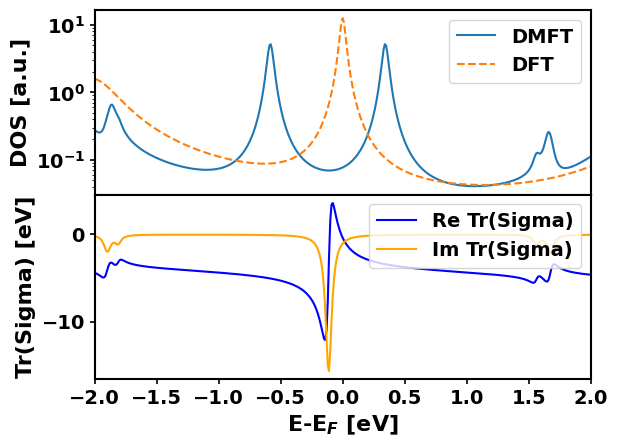

2:  |F(x)| = 18.2906; step 1
Iteration :  4
Occupation : 10.78730 Chemical potential : 0.08168 Error : 26.25909906 Relative Error : 0.03879494


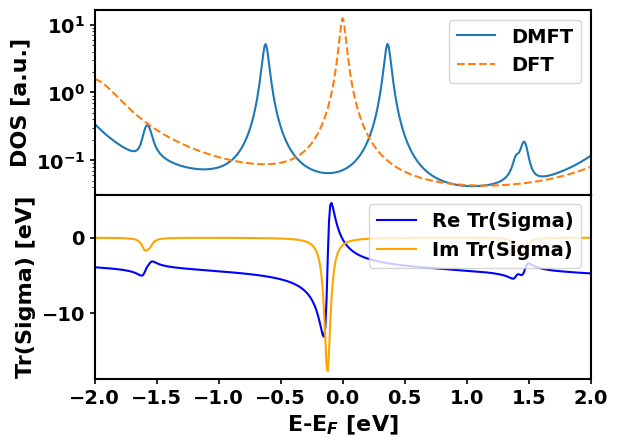

3:  |F(x)| = 4.52819; step 1
Iteration :  5
Occupation : 10.78730 Chemical potential : 0.09038 Error : 19.54655691 Relative Error : 0.02959249


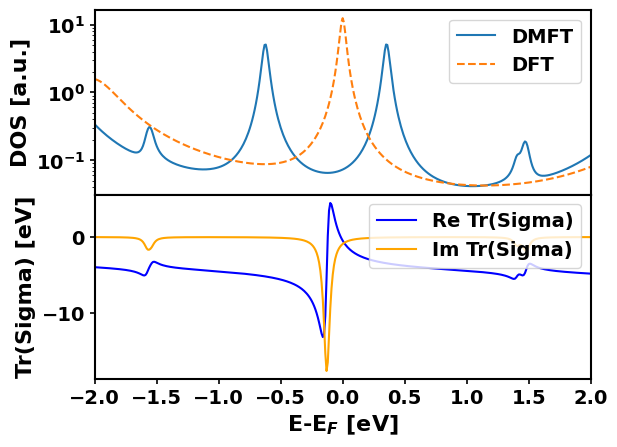

4:  |F(x)| = 2.72152; step 1
Iteration :  6
Occupation : 10.78730 Chemical potential : 0.09788 Error : 28.33925656 Relative Error : 0.04299202
Iteration :  7
Occupation : 10.78730 Chemical potential : 0.10148 Error : 31.07202663 Relative Error : 0.04707195
Iteration :  8
Occupation : 10.78730 Chemical potential : 0.10347 Error : 35.27349112 Relative Error : 0.05340424
Iteration :  9
Occupation : 10.78730 Chemical potential : 0.10477 Error : 36.91171950 Relative Error : 0.05588274
Iteration : 10
Occupation : 10.78730 Chemical potential : 0.10564 Error : 37.92533428 Relative Error : 0.05741709
Iteration : 11
Occupation : 10.78730 Chemical potential : 0.10620 Error : 38.58371441 Relative Error : 0.05841380
Iteration : 12
Occupation : 10.78730 Chemical potential : 0.10658 Error : 39.01550698 Relative Error : 0.05906750
Iteration : 13
Occupation : 10.78730 Chemical potential : 0.10844 Error : 38.22362360 Relative Error : 0.05798708


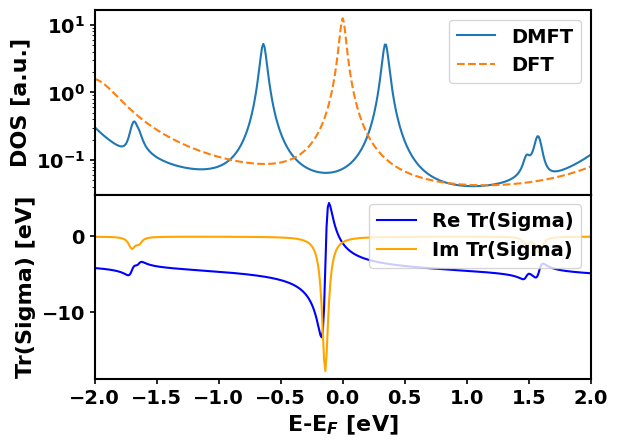

5:  |F(x)| = 5.08377; step 1
Iteration : 14
Occupation : 10.78730 Chemical potential : 0.10932 Error : 37.24091375 Relative Error : 0.05745190


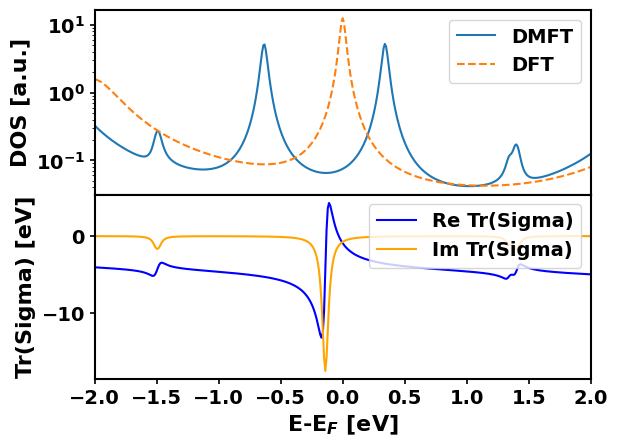

6:  |F(x)| = 5.31065; step 1
Iteration : 15
Occupation : 10.78730 Chemical potential : 0.11414 Error : 20.48230000 Relative Error : 0.03238792


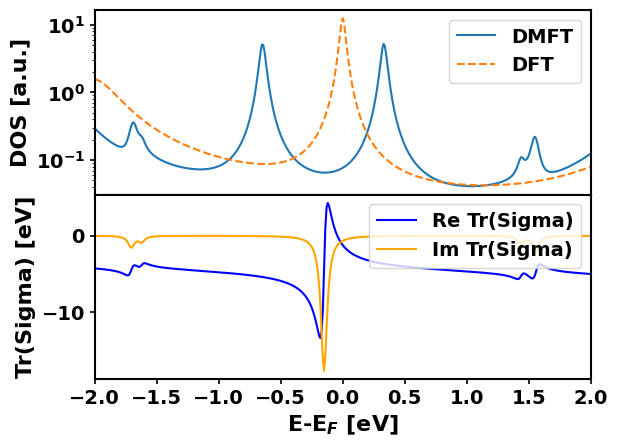

7:  |F(x)| = 2.74303; step 1
Iteration : 16
Occupation : 10.78730 Chemical potential : 0.12315 Error : 18.33072848 Relative Error : 0.03004299


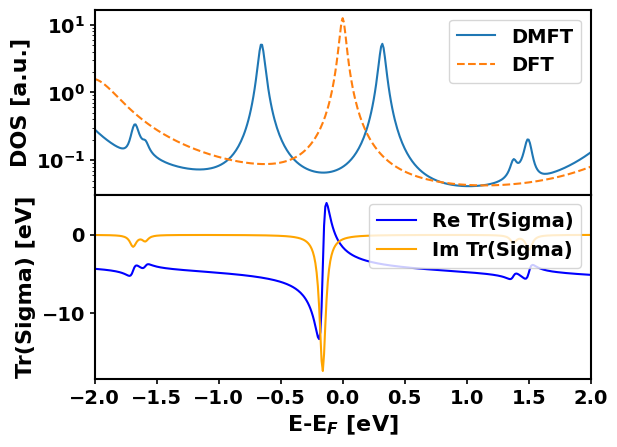

8:  |F(x)| = 2.58729; step 1
Iteration : 17
Occupation : 10.78730 Chemical potential : 0.12887 Error : 23.37611004 Relative Error : 0.03779038
Iteration : 18
Occupation : 10.78730 Chemical potential : 0.13279 Error : 18.64456996 Relative Error : 0.03043706
Iteration : 19
Occupation : 10.78730 Chemical potential : 0.13543 Error : 22.58671370 Relative Error : 0.03695943
Iteration : 20
Occupation : 10.78730 Chemical potential : 0.13717 Error : 25.56437124 Relative Error : 0.04189338
Iteration : 21
Occupation : 10.78730 Chemical potential : 0.13834 Error : 26.46512767 Relative Error : 0.04337393
Iteration : 22
Occupation : 10.78730 Chemical potential : 0.13911 Error : 26.99014358 Relative Error : 0.04423505
Iteration : 23
Occupation : 10.78730 Chemical potential : 0.13962 Error : 27.33066782 Relative Error : 0.04479331
Iteration : 24
Occupation : 10.78730 Chemical potential : 0.13973 Error : 30.97362907 Relative Error : 0.05007272


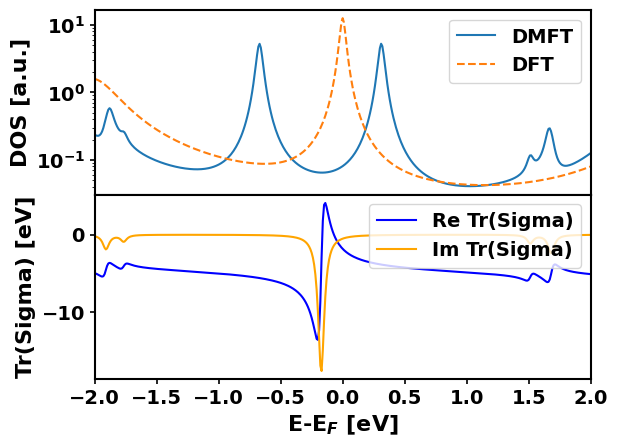

9:  |F(x)| = 3.86808; step 1
Iteration : 25
Occupation : 10.78730 Chemical potential : 0.14220 Error : 20.52035099 Relative Error : 0.03393139


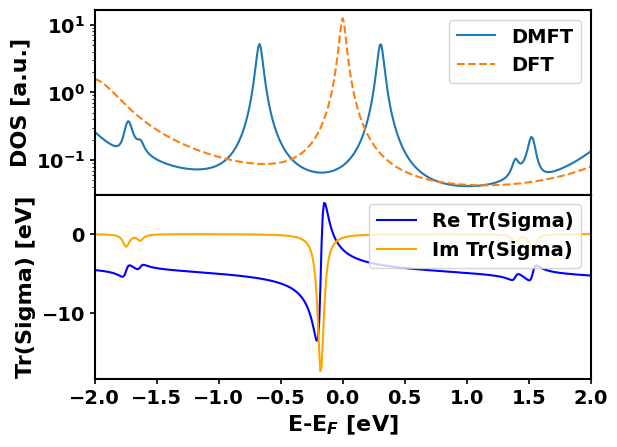

10:  |F(x)| = 2.57085; step 1
Iteration : 26
Occupation : 10.78730 Chemical potential : 0.14664 Error : 15.00552483 Relative Error : 0.02511811


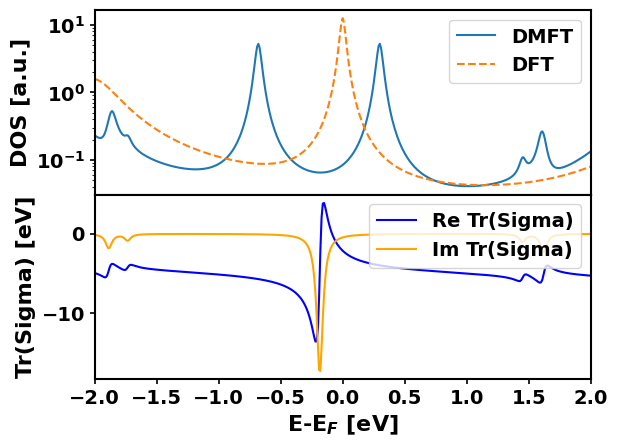

11:  |F(x)| = 1.90496; step 1
Iteration : 27
Occupation : 10.78730 Chemical potential : 0.15406 Error : 15.89911235 Relative Error : 0.02725391
Iteration : 28
Occupation : 10.78730 Chemical potential : 0.15650 Error : 17.27598183 Relative Error : 0.02922798
Iteration : 29
Occupation : 10.78730 Chemical potential : 0.15654 Error : 21.10234532 Relative Error : 0.03540195
Iteration : 30
Occupation : 10.78730 Chemical potential : 0.15621 Error : 21.98027432 Relative Error : 0.03680359
Iteration : 31
Occupation : 10.78730 Chemical potential : 0.15597 Error : 21.94198742 Relative Error : 0.03673173
Iteration : 32
Occupation : 10.78730 Chemical potential : 0.15581 Error : 21.86364417 Relative Error : 0.03659875
Iteration : 33
Occupation : 10.78730 Chemical potential : 0.15567 Error : 21.74453459 Relative Error : 0.03639887
Iteration : 34
Occupation : 10.78730 Chemical potential : 0.15558 Error : 21.68104531 Relative Error : 0.03629247
Iteration : 35
Occupation : 10.78730 Chemical potential : 

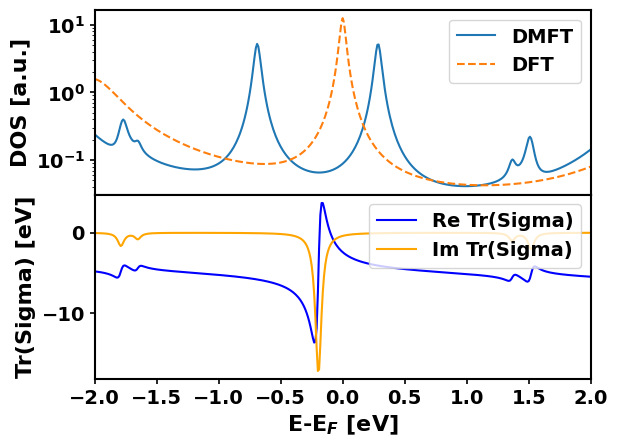

12:  |F(x)| = 2.34299; step 1
Iteration : 36
Occupation : 10.78730 Chemical potential : 0.16254 Error : 20.73048963 Relative Error : 0.03518334
Iteration : 37
Occupation : 10.78730 Chemical potential : 0.16439 Error : 16.92119896 Relative Error : 0.02890054


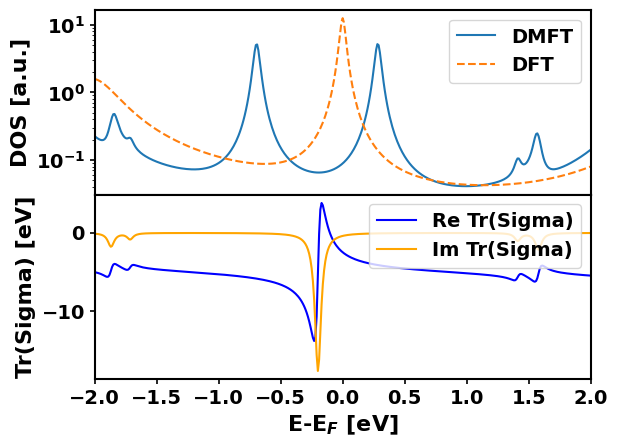

13:  |F(x)| = 2.12087; step 0.386697
Iteration : 38
Occupation : 10.78730 Chemical potential : 0.16865 Error : 14.08529679 Relative Error : 0.02447051


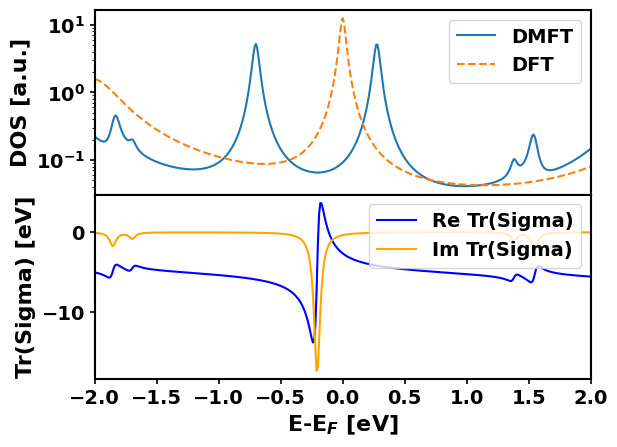

14:  |F(x)| = 1.76105; step 1
Iteration : 39


KeyboardInterrupt: 

In [20]:
dmft.it = 0
dmft.solve(dmft.delta, alpha=1.0, callback=callback)

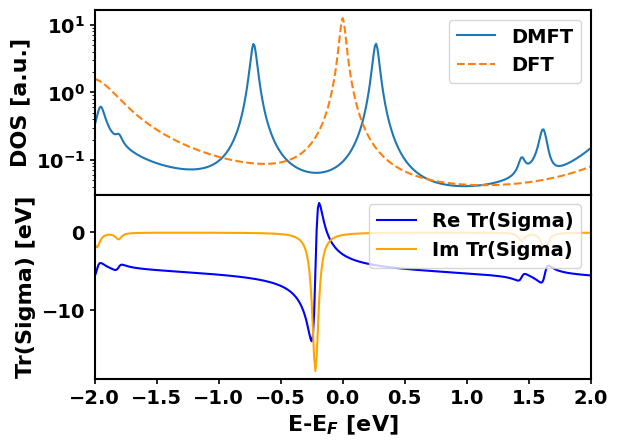

In [15]:
callback(semilogy=True)

In [17]:
import os

output_folder = f"output/lowdin/local"
os.makedirs(output_folder, exist_ok=True)
sigma_data = dmft.Sigma(z_ret)

_Sigma = (
    lambda z: -double_counting.diagonal()[:, None]
    - gfloc_with_dccorrection.mu
    + gfloc_with_dccorrection.Sigma(z)[idx_inv]
)
dmft_sigma_file = f"{output_folder}/dmft_sigma.npy"
save_sigma(_Sigma(z_ret), dmft_sigma_file, nspin)

gfloc_data = gfloc_with_dccorrection(z_ret)
np.save(f"{output_folder}/dmft_gfloc.npy", gfloc_data)

np.save(f"{output_folder}/opt_delta_dmft", dmft.delta)
np.save(f"{output_folder}/opt_mu_dmft", gfloc_with_dccorrection.mu)


In [18]:
from __future__ import annotations

import pickle

import numpy as np
from mpi4py import MPI
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.block_tridiag import greenfunction
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc
from qtpyt.projector import expand

comm = MPI.COMM_WORLD
rank = comm.Get_rank()


class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


def run(outputfile):
    gd = GridDesc(energies, 1, float)
    T = np.empty(gd.energies.size)
    for e, energy in enumerate(gd.energies):
        T[e] = gf.get_transmission(energy)

    T = gd.gather_energies(T)

    if comm.rank == 0:
        np.save(outputfile, (energies, T.real))


data_folder = "./output/lowdin"
dmft_data_folder = "./output/lowdin/local"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy", allow_pickle=True)
dmft_sigma_file = f"{dmft_data_folder}/dmft_sigma.npy"

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
    hs_list_ii = pickle.load(f)
with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
    hs_list_ij = pickle.load(f)

nodes = [0, 810, 1116, 1278, 1584, 2394]

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [(0, self_energy[0]), (len(hs_list_ii) - 1, self_energy[1])],
    solver="dyson",
    eta=eta,
)

# Add the DMFT self-energy for transmission
if comm.rank == 0:
    dmft_sigma = load(dmft_sigma_file)
else:
    dmft_sigma = None

# Transmission function calculation
imb = 2  # index of molecule block from the nodes list
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
idx_molecule = (
    index_active_region - nodes[imb]
)  # indices of active region w.r.t molecule

dmft_sigma = comm.bcast(dmft_sigma, root=0)
self_energy[2] = dmft_sigma
gf.selfenergies.append((imb, self_energy[2]))

outputfile = f"{dmft_data_folder}/dmft_transmission.npy"
run(outputfile)
gf.selfenergies.pop()


KeyboardInterrupt: 